# PyTorch Workflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build the model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating the model (inference)",
                      5: "saving and loading the model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build the model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating the model (inference)',
 5: 'saving and loading the model',
 6: 'putting it all together'}

In [2]:
import torch
import torch as nn  # Basic building blocks for neural networks graphs
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
False


## Step 1. Data (prepare and load)

- Part 1: Get data (e.g., image, voice) into a numerical representation.
- Part 2: Build a model to learn patterns in that numerical representation.

In [3]:
# Create *known* parameters for linear regression
weight = 0.7
bias = 0.3

# Create the data
start, interval, end = 0, 0.02, 1
X = torch.arange(start, end, interval).unsqueeze(dim=1)
y = weight*X + bias  # y_ture for supervised learning; the goal of y_hat

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting the data into training and testing sets.
Possibly one of the most important concepts in ML.

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)
# For splitting data into random train and test subsets: sklearn.model_selection.train_test_split

(40, 40, 10, 10)

In [6]:
# Visulazation
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plot the training and testing data and compare predictions.
    """


    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    # Plot testing data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    # Plot predictions if they exist
    if predictions is not None:
        plt.scatter(X_test, predictions, c='r', s=4, label="Predictions")

    # Show the legends
    plt.legend(prop={"size": 14})

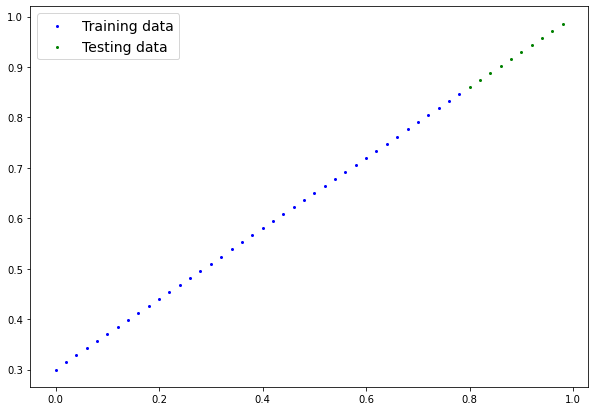

In [7]:
plot_predictions()

## Step 2. Build the model.

What our model does:
* Start with random values (weights & bias).
* Look at the training data and adjust the random values to better represent the ideal values.

In [8]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module):  # first, subclass `nn.Module` that contains all the building blocks for NN.
    def __init__(self):  # Next, initialize `model parameters`` to be used in various computation.
        super().__init__()  # A method in the parent class can be called in Python using the super() function.
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,  
                                                dtype=torch.float32))

        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float32))
        '''
        Note `requires_grad`` means PyTorch will track the gradients of this specific parameter 
             for use with `torch.autograd` and gradient descent.
        '''

    '''
    Any subclass of `nn.Module` needs to override `forward()`.
    (This defines the forward computation of the model.)
    '''
    # forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [9]:
# Create random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
print(model_0.parameters())  # generator 
print(list(model_0.parameters()))  # list
# List the named parameters
print(model_0.state_dict())  # dictionary

<generator object Module.parameters at 0x0000016D93040F90>
[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [10]:
print(f"The goal is to get our weights and bias, i.e., {model_0.state_dict().get('weights')} and {model_0.state_dict().get('bias')},")
print(f"closer to the targets, i.e., {weight} and {bias}.")

The goal is to get our weights and bias, i.e., tensor([0.3367]) and tensor([0.1288]),
closer to the targets, i.e., 0.7 and 0.3.


In [11]:
# Making prediction using `torch.inference_mode()`. 
# When we pass the data through our model, it's going to run it through `forward()` method.
y_preds = model_0(X_test)
print(y_preds)

with torch.inference_mode():  # or with torch.no_grad()
    y_preds = model_0(X_test)
print(y_preds)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


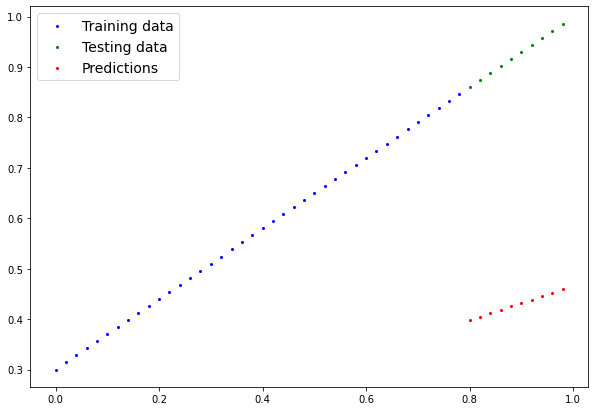

In [12]:
plot_predictions(predictions=y_preds)

### 3. Train model

1. Loss function: A function to measure how wrong your model's predictions are to the target outputs, providing a scalar value. The lower the better.
2. Optimizer: takes into the loss of the model and adjusts the model's parameters.

In [13]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)  # possibly the most important hyperparameters 

### Building a training loop (and a testing loop) in PyTorch

0. Loop through the data and do ...
1. Forward pass (this involves data moving through our model's forward() function) to make predictions on data, aka forward propagation.
2. Calculate the loss (compare a forward pass predictions to ground truth labels)
3. Optimaizer zero_grad()
4. Loss backward - move backward through the network to compute the gradients of the chosen loss function w.r.t. each trainable parameter of our model through .backward() or backpropagation.
5. Optimizer step - use the optimizer to update our model's parameters to improve the loss via w = w - a*dL/dw

In [17]:
# An epoch is one loop through the data
epochs = 1

for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()  # set all parameters that require gradients

    # 1. Forward pass
    y_pred = model_0.forward(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero_grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss w.r.t the parameter of our model
    loss.backward()
    
    # 5. Step the optimizer (perform the gradient descent)
    optimizer.step()  # by default how optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop
